In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from patsy import dmatrices
import os
import dotenv
import statsmodels.api as sm

os.chdir(dotenv.find_dotenv().replace('.env', ''))
from src.data_correction import pseudobatch_transform

In [3]:
!cp ../fermentation_simulator/simulated_data/varying_sample_volume.csv data/

In [16]:
df = pd.read_csv('data/varying_sample_volume.csv')
df['mu_percent_relerror'] = df['abs_relerror_mu_hat'] * 100
df['Yxp_percent_relerror'] = df['abs_relerror_Yxp_hat'] * 100
df['Yxs_percent_relerror'] = df['abs_relerror_Yxs_hat'] * 100
df

,Kc_s,Yxs,abs_relerror_Yxp_hat,abs_relerror_Yxs_hat,abs_relerror_mu_hat,mu0,mu_max,n_samples,product_yield_frac,s_f,sample_volume_fraction,mu_percent_relerror,Yxp_percent_relerror,Yxs_percent_relerror
0,0.15,1.85,2.702883e-16,2.400482e-16,7.917315e-08,0.1,0.3,10.0,0.4,100.0,0.000000,0.000008,2.702883e-14,2.400482e-14
1,0.15,1.85,3.720055e-03,1.898371e-01,1.604912e-01,0.1,0.3,10.0,0.4,100.0,0.088889,16.049122,3.720055e-01,1.898371e+01
2,0.15,1.85,1.374309e-02,5.099017e-01,3.374706e-01,0.1,0.3,10.0,0.4,100.0,0.177778,33.747058,1.374309e+00,5.099017e+01
3,0.15,1.85,4.608295e-02,1.154008e+00,5.347180e-01,0.1,0.3,10.0,0.4,100.0,0.266667,53.471802,4.608295e+00,1.154008e+02
4,0.15,1.85,1.858238e-01,2.894263e+00,7.574836e-01,0.1,0.3,10.0,0.4,100.0,0.355556,75.748357,1.858238e+01,2.894263e+02
5,0.15,1.85,8.999232e-02,2.243805e+00,1.013365e+00,0.1,0.3,10.0,0.4,100.0,0.444444,101.336485,8.999232e+00,2.243805e+02
6,0.15,1.85,4.793084e-01,3.564993e+00,1.313956e+00,0.1,0.3,10.0,0.4,100.0,0.533333,131.395618,4.793084e+01,3.564993e+02
7,0.15,1.85,4.801960e-01,2.501135e+00,1.678260e+00,0.1,0.3,10.0,0.4,100.0,0.622222,167.826045,4.801960e+01,2.501135e+02
8,0.15,1.85,4.993003e-01,2.036261e+00,2.140757e+00,0.1,0.3,10.0,0.4,100.0,0.711111,214.075695,4.993003e+01,2.036261e+02
9,0.15,1.85,5.164278e-01,1.781852e+00,2.774727e+00,0.1,0.3,10.0,0.4,100.0,0.800000,277.472733,5.164278e+01,1.781852e+02


## What is the error when calculating the growth rate

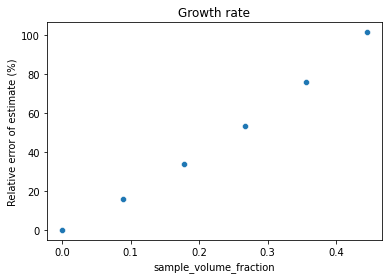

In [21]:
sns.scatterplot(x = 'sample_volume_fraction', y = 'mu_percent_relerror', data =df.query("sample_volume_fraction < 0.5"))
#sns.scatterplot(x = 'sample_volume_fraction', y = 'Yxs_percent_relerror', data =df)
plt.ylabel("Relative error of estimate (%)")
plt.title("Growth rate")
plt.savefig("reports/figures/varying_sample_volume_fraction.png", dpi=300)

In [21]:
y = fitted_growth_rates['growth_rate_raw_error']
X = sm.add_constant(fitted_growth_rates['sample_volume_fraction'])

model_error = sm.OLS(endog=y, exog=X)
res_error = model_error.fit()
res_error.params[1]
print(res_error.summary())

                              OLS Regression Results                             
Dep. Variable:     growth_rate_raw_error   R-squared:                       0.891
Model:                               OLS   Adj. R-squared:                  0.885
Method:                    Least Squares   F-statistic:                     146.8
Date:                   Mon, 12 Sep 2022   Prob (F-statistic):           4.33e-10
Time:                           10:55:02   Log-Likelihood:                 31.414
No. Observations:                     20   AIC:                            -58.83
Df Residuals:                         18   BIC:                            -56.84
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

We see that in this case the error of the estimated growth rate increase by ~0.03 of the sample volume fraction. Leading when sampling 30% of the total volume growth rate estimate will be biased by 8%.

## What is the error when calculating the glucose biomass yield

In [22]:
grps = df_before_sample_removed.groupby('sample_volume_fraction')
fitted_co2_yields = pd.DataFrame()
for name, grp in grps:

    ## Fitting model with corrected biomass
    y = grp['pseudo_Biomass'].astype(float).to_numpy()
    X = sm.add_constant(grp['pseudo_CO2']).astype(float).to_numpy()
    
    model_pseudo = sm.OLS(endog=y, exog=X)
    res_pseudo = model_pseudo.fit()
    mu_pseudo = res_pseudo.params[1]

    ## Fitting model with raw biomass
    y = grp['m_Biomass'].astype(float).to_numpy()
    X = sm.add_constant(grp['m_CO2']).astype(float).to_numpy()
    
    model_raw = sm.OLS(endog=y, exog=X)
    res_raw = model_raw.fit()
    mu_raw = res_raw.params[1]


    fitted_co2_yields = pd.concat([
        fitted_co2_yields,
        pd.DataFrame([[name, mu_pseudo, mu_raw]], columns=['sample_volume_fraction', 'co2_yield_pseudo', 'co2_yield_raw'])
    ])

In [23]:
# Calculate relative error
fitted_co2_yields['co2_yield_pseudo_error'] = (fitted_co2_yields['co2_yield_pseudo'] - 0.1**(-1)) / 0.1**(-1)
fitted_co2_yields['co2_yield_raw_error'] = (fitted_co2_yields['co2_yield_raw'] - 0.1**(-1)) / 0.1**(-1)

<AxesSubplot:xlabel='sample_volume_fraction', ylabel='co2_yield_pseudo_error'>

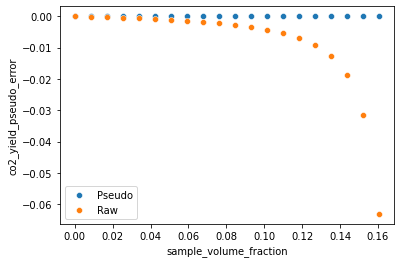

In [24]:
sns.scatterplot(x = 'sample_volume_fraction', y = 'co2_yield_pseudo_error', data =fitted_co2_yields, label='Pseudo')
sns.scatterplot(x = 'sample_volume_fraction', y = 'co2_yield_raw_error', data =fitted_co2_yields, label='Raw')
